In [1]:
import numpy as np
import cv2
import os
from os import listdir
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

import pandas as pd 

import cv2
import os, gc, sys, glob
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from keras.losses import MeanSquaredError
from keras.models import Sequential, load_model

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras import applications
from keras.callbacks import ReduceLROnPlateau

from keras.layers import LayerNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [4]:
default_image_size = tuple((72, 72))
resized_image_size = tuple((72,72))
directory_root = 'E:\\PROJECT_MODIFIED\\Augmented\\Resized\\72x72'

In [5]:
# Function to convert image to array.
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            rgbImg=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(rgbImg, resized_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
# Reading the images from the dataset folder.
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed!")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing BANANA_DISEASE_LEAF STEAK ...
[INFO] Processing BANANA_HEALTHY ...
[INFO] Processing BLACK-PEPPER_DISEASED_ANTHRACNOSE ...
[INFO] Processing BLACK-PEPPER_HEALTHY ...
[INFO] Processing BRINJAL_DISEASED_LEAF BLIGHT ...
[INFO] Processing BRINJAL_DISEASED_LEAF CURL ...
[INFO] Processing BRINJAL_DISEASED_LEAF SPOT ...
[INFO] Processing BRINJAL_DISEASED_MOLD ...
[INFO] Processing BRINJAL_HEALTHY ...
[INFO] Processing CABBAGE_HEALTHY ...
[INFO] Processing CASSAVA_DISEASED_LEAF SPOT ...
[INFO] Processing CASSAVA_DISEASED_MOSAIC ...
[INFO] Processing CHILLI-PEPPER_CHLOROSIS ...
[INFO] Processing CHILLI-PEPPER_DISEASED_LEAF CURL ...
[INFO] Processing CHILLI-PEPPER_DISEASED_LEAF SPOT ...
[INFO] Processing CHILLI-PEPPER_DISEASED_MOSIAC ...
[INFO] Processing CHILLI-PEPPER_HEALTHY ...
[INFO] Processing CITRUS_DISEASED_MITE ...
[INFO] Image loading completed!


In [7]:
# Assign the classes to images.
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [8]:
from collections import Counter
print(Counter(label_list).keys() )
print(Counter(label_list).values())

dict_keys(['BANANA_DISEASE_LEAF STEAK', 'BANANA_HEALTHY', 'BLACK-PEPPER_DISEASED_ANTHRACNOSE', 'BLACK-PEPPER_HEALTHY', 'BRINJAL_DISEASED_LEAF BLIGHT', 'BRINJAL_DISEASED_LEAF CURL', 'BRINJAL_DISEASED_LEAF SPOT', 'BRINJAL_DISEASED_MOLD', 'BRINJAL_HEALTHY', 'CABBAGE_HEALTHY', 'CASSAVA_DISEASED_LEAF SPOT', 'CASSAVA_DISEASED_MOSAIC', 'CHILLI-PEPPER_CHLOROSIS', 'CHILLI-PEPPER_DISEASED_LEAF CURL', 'CHILLI-PEPPER_DISEASED_LEAF SPOT', 'CHILLI-PEPPER_DISEASED_MOSIAC', 'CHILLI-PEPPER_HEALTHY', 'CITRUS_DISEASED_MITE'])
dict_values([210, 198, 132, 264, 132, 108, 618, 72, 1212, 498, 138, 1272, 132, 1074, 84, 198, 432, 698])


In [9]:
print(n_classes)

18


In [10]:
image_labels

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [11]:
# Convert the array to a NumPy list and normalise it.
np_image_list = np.array(image_list, dtype = np.float32)
print("Total Images" , " : " ,len(np_image_list))

Total Images  :  7472


In [12]:
# del image_list

In [13]:
print("[INFO] Spliting data into train set and test set ...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size = 0.5, random_state = 42) 
print("[INFO] Spliting complete!")
print("x_Train" ," : " , x_train.shape)
print("y_Train" ," : " , y_train.shape)
print("x_Test" ," : " , x_test.shape)
print("y_Test" ," : " , y_test.shape)

[INFO] Spliting data into train set and test set ...
[INFO] Spliting complete!
x_Train  :  (3736, 72, 72, 3)
y_Train  :  (3736, 18)
x_Test  :  (3736, 72, 72, 3)
y_Test  :  (3736, 18)


In [14]:
# del np_image_list
# del image_labels

In [23]:
input_shape = (72, 72, 3)

learning_rate = 0.00001
weight_decay = 0.00001
batch_size = 6
image_size = 72
num_epochs = 300
patch_size = 12  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers

transformer_layers = 8
mlp_head_units = [1024,1024]
num_classes=n_classes;

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [25]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
    return x

In [26]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 12 X 12
Patches per image: 36
Elements per patch: 432


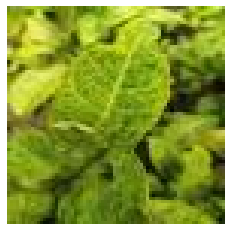

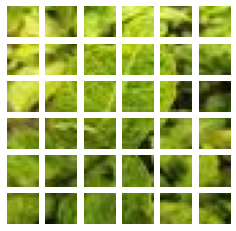

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [28]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [29]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.5
        )(x1, x1)
        
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.5)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='softmax' )(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [30]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 5 Accuracy: {round(top_5_accuracy * 100, 2)}%")
    print(f"Test Precision: {round(precision * 100, 2)}%")
    print(f"Test Recall: {round(precision * 100, 2)}%")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/300
561/561 [==============================] - 27s 36ms/step - loss: 2.5767 - accuracy: 0.2097 - val_loss: 2.3719 - val_accuracy: 0.2888
Epoch 2/300
561/561 [==============================] - 20s 36ms/step - loss: 2.3497 - accuracy: 0.2731 - val_loss: 2.2450 - val_accuracy: 0.3289
Epoch 3/300
561/561 [==============================] - 21s 37ms/step - loss: 2.2319 - accuracy: 0.3147 - val_loss: 2.1558 - val_accuracy: 0.3422
Epoch 4/300
561/561 [==============================] - 20s 35ms/step - loss: 2.0969 - accuracy: 0.3584 - val_loss: 2.0770 - val_accuracy: 0.3850
Epoch 5/300
561/561 [==============================] - 19s 35ms/step - loss: 1.9828 - accuracy: 0.3870 - val_loss: 1.9801 - val_accuracy: 0.3850
Epoch 6/300
561/561 [==============================] - 20s 35ms/step - loss: 1.8564 - accuracy: 0.4274 - val_loss: 1.9048 - val_accuracy: 0.4144
Epoch 7/300
561/561 [==============================] - 20s 35ms/step - loss: 1.7235 - accuracy: 0.4661 - val_loss: 1.8307 - val_ac

UnknownError: Failed to WriteFile: ./tmp\checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate16872195611489750056 : There is not enough space on the disk.
; operation in progress [Op:SaveV2]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(25, 15))
xmin = 0
xmax = 100
ymin = 0.0
ymax = 1.0
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
    
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])

plt.plot(epochs, acc, 'g--', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'g', label = 'Validation accuracy')
plt.title('Training and validation Accuracy')
plt.legend(bbox_to_anchor=(1, 0.2))

plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(25, 15))
    #Plot the Result
xmin = 0
xmax = 100
ymin = 0.0
ymax = 2.0

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
    
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])

plt.plot(epochs, loss, 'r--', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and validation loss' , fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.2))

plt.grid()
plt.show()